# Arbitrary Cost Function

The goal is simple make a function that takes `y_true` and `y_pred` and computes a cost for it. I'm going to try this for crazy distributions to see if I can trivially make things like PyTorch, TensorFlow and Keras optimise stats functions.

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pymc3 as pm
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as graph
import seaborn as sns

from rosey.helpers import vec_to_array

graph.style.use('fivethirtyeight')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Using TensorFlow backend.


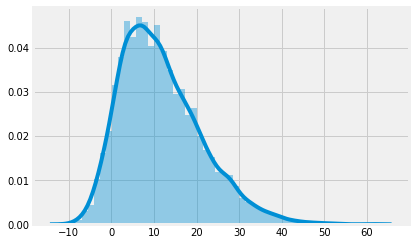

In [2]:
sns.distplot(stats.skewnorm(4, 0, 15).rvs(10000))
graph.show()

In [3]:
# True params
m, b, sigma, skew = 1.5, 95, 20, 4

(1000,) (1000,)


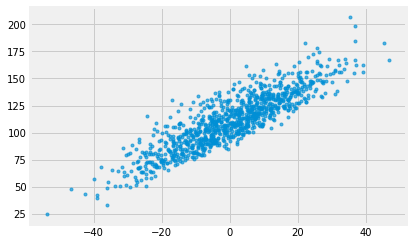

In [4]:
x = stats.norm(0, 15).rvs(1000)
y = m * x + b + stats.skewnorm(skew, 0, sigma).rvs(x.shape)
y = y.flatten()

print(x.shape, y.shape)

graph.plot(x, y, '.', alpha=0.66)
graph.show()

# Wrong Fit (Baseline)

Assuming it is a normal distribution

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:              148.50708496603136
Method:                          IRLS   Log-Likelihood:                -3918.3
Date:                Fri, 01 Jun 2018   Deviance:                   1.4821e+05
Time:                        12:29:05   Pearson chi2:                 1.48e+05
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.7764      0.385    287.415      0.000     110.021     111.532
x1             1.4937      0.026     58.446      0.000       1.444       1.544
==============================================================================
"""

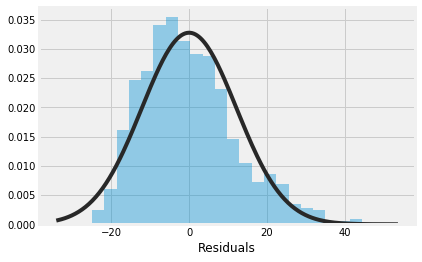

In [5]:
glm_results = sm.GLM(y, sm.add_constant(x)).fit()
display(glm_results.summary())

sns.distplot(glm_results.resid_pearson, kde=False, fit=stats.norm)
graph.xlabel('Residuals')
graph.show()

Notice that the intercept is very wrong and the residuals are not normally distributed.

The cool thing to notice is that the slope is a good estimate

# Bayesian Solution

easy because we already can have arbitrary likelihoods trivially in python 

In [6]:
with pm.Model() as bayes_soln:
    # Priors
    slope = pm.Normal('m', mu=0, sd=100**2)
    bias = pm.Normal('b', mu=0, sd=100**2)
    sd = pm.HalfNormal('sd', sd=100**2)
    skewness = pm.Normal('skewness', mu=0, sd=100**2)
    
    # Likelihood
    obs = pm.SkewNormal('obs', mu=slope * x + bias, sd=sd, alpha=skewness, observed=y)
    
    # Approx Posterior
    infer_engine = pm.ADVI()
    approx_fit = pm.fit(n=25000, method=infer_engine)

Average Loss = 5,460.4: 100%|██████████| 25000/25000 [00:23<00:00, 1085.15it/s]
Finished [100%]: Average Loss = 5,460.3


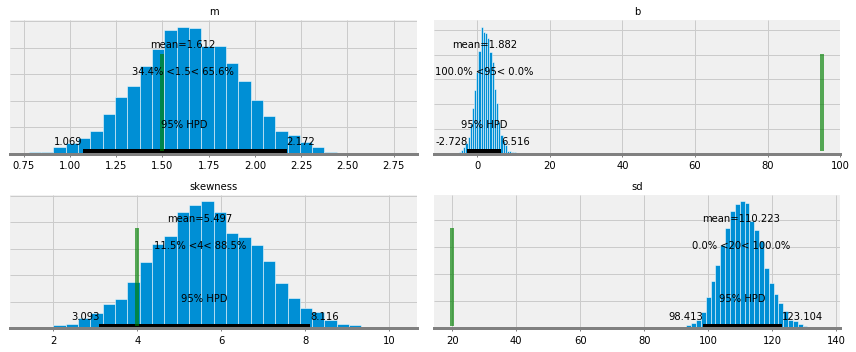

In [7]:
approx_trace = approx_fit.sample(5000)

pm.plot_posterior(approx_trace, ref_val=[m, b, skew, sigma])
graph.show()

There's no sugar coating it... The ADVI approximation was terrible. Let's actually sample the posterior and just get the correct answer.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [skewness, sd_log__, b, m]
100%|██████████| 20500/20500 [01:09<00:00, 296.51it/s]
The acceptance probability does not match the target. It is 0.8879128693419054, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886208097423741, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987085456830478, but should be close to 0.8. Try to increase the number of tuning steps.


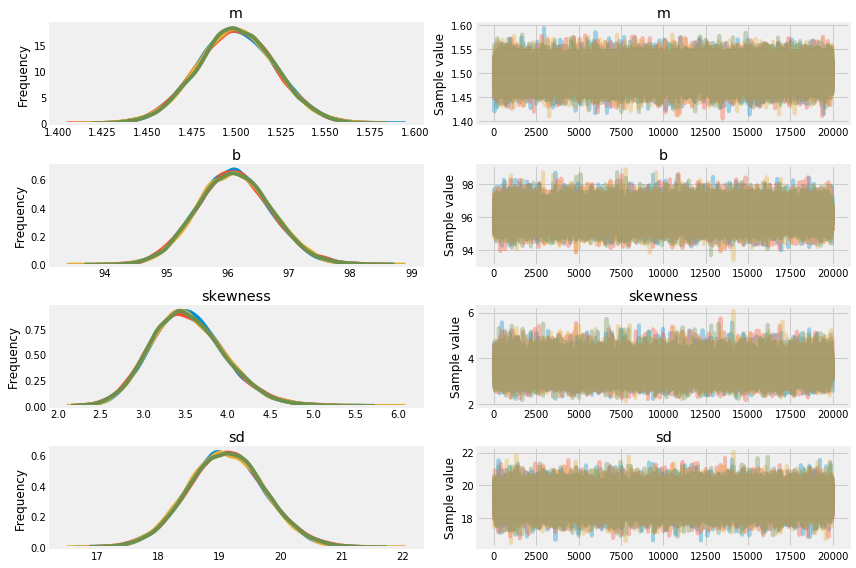

In [8]:
with bayes_soln:
    # Sample Posterior
    trace = pm.sample(20000)
    
    pm.traceplot(trace)
    graph.show()

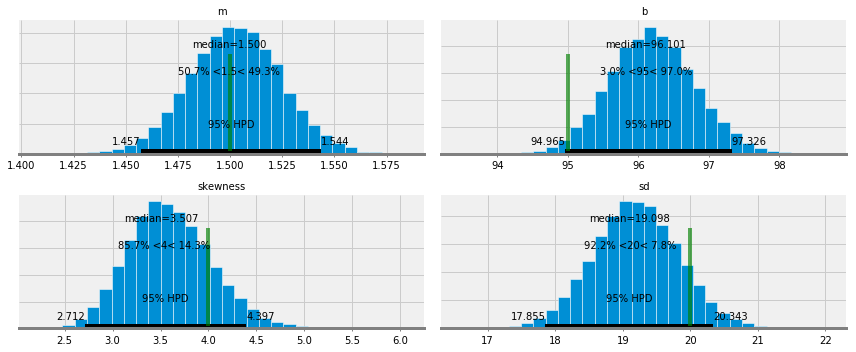

In [9]:
pm.plot_posterior(trace[::4], point_estimate='median', ref_val=[m, b, skew, sigma])
graph.show()

As _ALWAYS_ the bayesian solution is the true answer. All parameters were correctly inferred.